### Additional Information

- Dataset has no missing values.
- Values are in kW of each 15 min. To convert values in kWh values must be divided by 4.
- Each column represent one client. Some clients were created after 2011. In these cases consumption were considered zero.
- All time labels report to Portuguese hour. However all days present 96 measures (24*4). 
- Every year in March time change day (which has only 23 hours) the values between 1:00 am and 2:00 am are zero for all points. Every year in October time change day (which has 25 hours) the values between 1:00 am and 2:00 am aggregate the consumption of two hours.


### Variable Information
- Data set were saved as txt using csv format, using semi colon (;).
- First column present date and time as a string with the following format 'yyyy-mm-dd hh:mm:ss'
- Other columns present float values with consumption in kW

In [70]:
data = 'LD2011_2014.txt'
file_path = 'LD2011_2014.txt'

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:

df = pd.read_csv(file_path, sep=';', parse_dates=[0],index_col=0)
print(df.head())

C:\Users\USER\AppData\Local\Temp\ipykernel_20268\2673259006.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,125,126,127,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,157,160,164,165,167,170,173,177,178,179,181,184,185,186,223,224,255,280,289,305,308,322,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,363,364,365,366,367,368,369,370) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=';', parse_dates=[0],index_col=0)


                    MT_001 MT_002 MT_003 MT_004 MT_005 MT_006 MT_007 MT_008  \
2011-01-01 00:15:00      0      0      0      0      0      0      0      0   
2011-01-01 00:30:00      0      0      0      0      0      0      0      0   
2011-01-01 00:45:00      0      0      0      0      0      0      0      0   
2011-01-01 01:00:00      0      0      0      0      0      0      0      0   
2011-01-01 01:15:00      0      0      0      0      0      0      0      0   

                    MT_009 MT_010  ... MT_361 MT_362 MT_363 MT_364 MT_365  \
2011-01-01 00:15:00      0      0  ...      0    0.0      0      0      0   
2011-01-01 00:30:00      0      0  ...      0    0.0      0      0      0   
2011-01-01 00:45:00      0      0  ...      0    0.0      0      0      0   
2011-01-01 01:00:00      0      0  ...      0    0.0      0      0      0   
2011-01-01 01:15:00      0      0  ...      0    0.0      0      0      0   

                    MT_366 MT_367 MT_368 MT_369 MT_370  
2011-

### Descriptive analysis

retain the index column

In [42]:
df.index = pd.to_datetime(df.index.to_series())

In [43]:
df_numeric = df.apply(pd.to_numeric,errors='coerce')
df_numeric = df_numeric.fillna(0)

In [44]:
df_numeric.index = df.index

In [45]:
df_kwh = df_numeric/4

In [46]:
def adjust_time_change_days(df):
    march_time_change = df[(df.index.month== 3) & (df.index.hour == 1)]
    # up to march 
    df.loc[march_time_change.index, :] = 0
        
    october_time_change = df[(df.index.month== 10) & (df.index.hour == 1)] 
    # df_kwh.loc[october_time_change] = df_kwh.loc[october_time_change].groupby(df.index.day).transform('sum')
    for day in october_time_change.index.date:
        day_data = df.loc[str(day)]
        if len(day_data) == 97:  # 25-hour day
            df.loc[day_data.index[1], :] += df.loc[day_data.index[2], :]
            df = df.drop(day_data.index[2])           
    return df

In [47]:
df_kwh_adjusted = adjust_time_change_days(df_kwh)

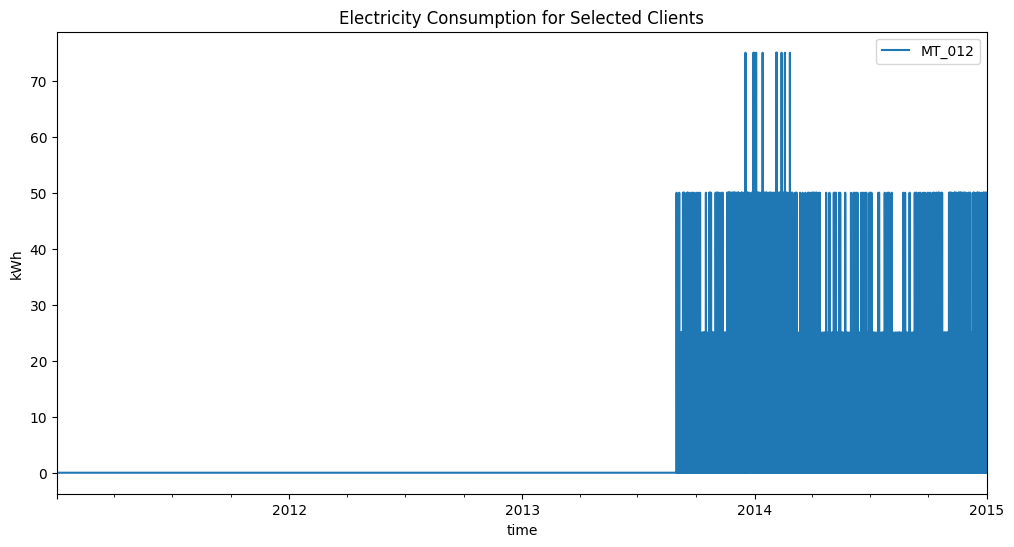

In [48]:
def plot_client_comsumption(client):
    df_kwh_adjusted[[client]].plot(figsize=(12,6))
    plt.title('Electricity Consumption for Selected Clients')
    plt.ylabel('kWh')
    plt.xlabel('time')
    plt.show()
    
plot_client_comsumption('MT_012')

In [35]:
print(df_kwh_adjusted.max())

MT_001       0.0
MT_002       0.0
MT_003       0.0
MT_004      62.5
MT_005      37.5
           ...  
MT_366       0.0
MT_367       0.0
MT_368       0.0
MT_369     312.5
MT_370    6600.0
Length: 370, dtype: float64


Distribution of Energy Consumption (Sample)

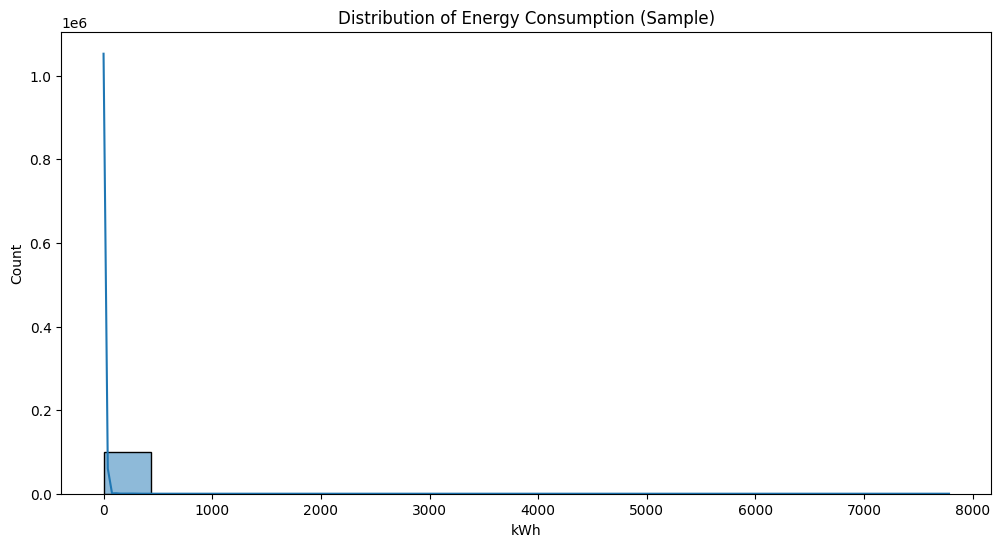

In [36]:
def plot_distribution_comsumption_rates(df_kwh_adjusted, sample_size=100000):
    sample_data = df_kwh_adjusted.values.flatten()
    sample_data = sample_data[~pd.isna(sample_data)]  # Remove NaNs
    sample_data = sample_data[:sample_size]  # Limit sample size for better performance
    
    plt.figure(figsize=(12, 6))
    sns.histplot(sample_data, kde=True)
    plt.title('Distribution of Energy Consumption (Sample)')
    plt.xlabel('kWh')
    plt.show()
    
plot_distribution_comsumption_rates(df_kwh_adjusted)

Daily Average Consumption

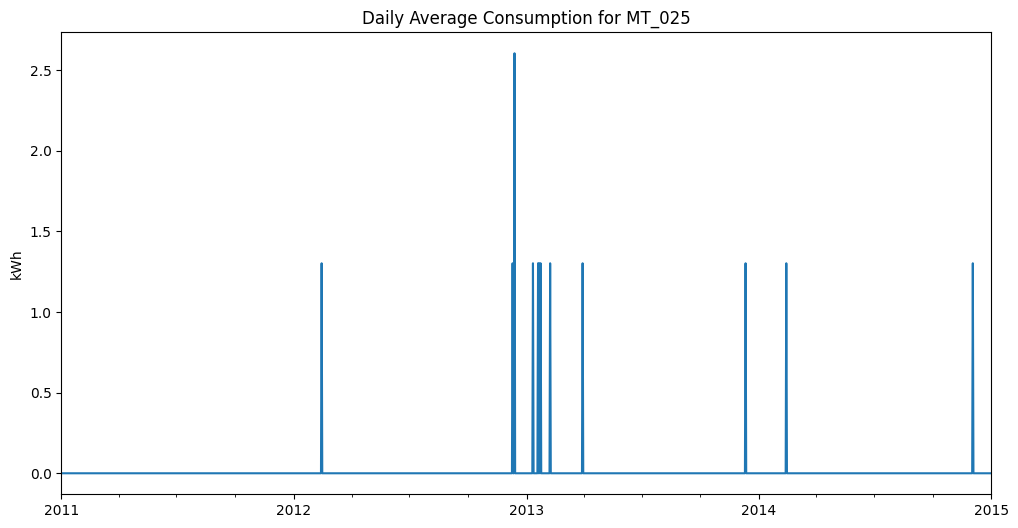

In [60]:
def plot_client_time_pattern(df_kwh_adjusted,client):
 # Time-based patterns (example for one client)
   client_col = df_kwh_adjusted.columns[client-1] # no array order
   df_kwh_adjusted[client_col].resample('D').mean().plot(figsize=(12, 6))
   plt.title(f'Daily Average Consumption for {client_col}')
   plt.ylabel('kWh')
   plt.show()
   
plot_client_time_pattern(df_kwh_adjusted,25)

Correlation between clients

- no significant negative correlation, which is when one client's consumption goes up and another’s goes down. may happen if clients are in different time zones or have inverse usage patterns.

- correlated clusters could represent clients in similar locations or under similar energy usage profiles, usefull perhaps.

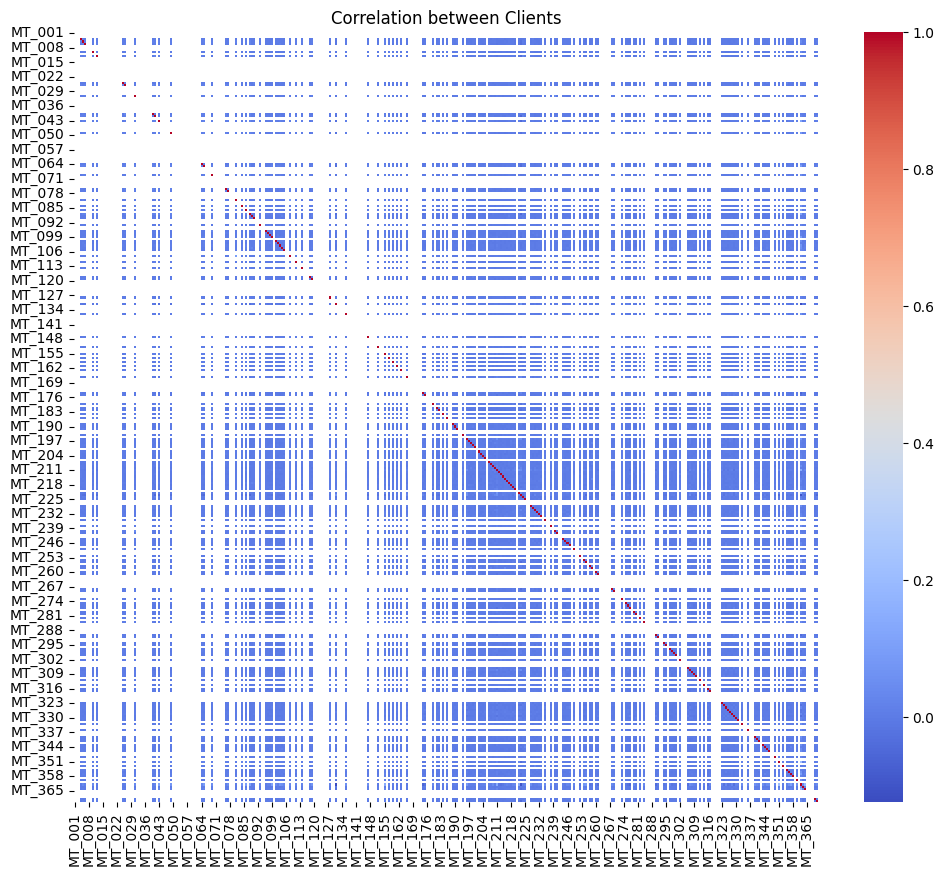

In [62]:
def correlation_clients(df_kwh):
    plt.figure(figsize=(12, 10))
    sns.heatmap(df_kwh_adjusted.corr(), cmap='coolwarm', annot=False)
    plt.title('Correlation between Clients')
    plt.show()
    
correlation_clients(df_kwh_adjusted)

Balacing

- no NaN values

In [68]:
# missing values
print(df_kwh_adjusted.isnull().sum().sum())

0


store in file in csv

In [72]:
df_kwh_adjusted.to_csv('df_kwh_adjusted.csv', sep=';', index=True)